In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy.linalg as la

from data import *
from models import train, RNN

# Below snippit taken from PyTorch quickstart tutorial
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cpu


In [105]:
sd_dataset = SingleDecisionDataset(32000)
train_dataloader = DataLoader(sd_dataset, batch_size=32)

model = RNN()
train(train_dataloader, model, device)

loss: 0.997689  [   32/32000]
loss: 0.934816  [ 3232/32000]
loss: 0.000480  [ 6432/32000]
loss: 0.000556  [ 9632/32000]
loss: 0.000262  [12832/32000]
loss: 0.000735  [16032/32000]
loss: 0.000267  [19232/32000]
loss: 0.000526  [22432/32000]
loss: 0.000468  [25632/32000]
loss: 0.000313  [28832/32000]


### Network output given input set

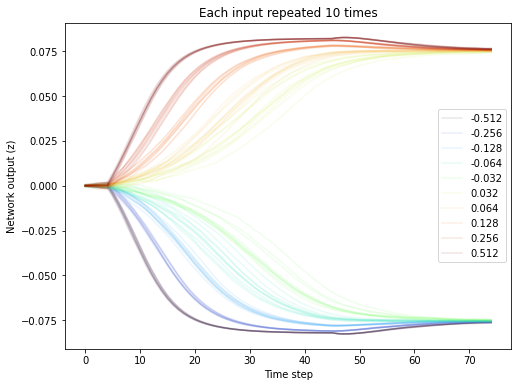

In [132]:
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

def plot_input_range(model, f_in_vec, in_params, 
                     num_repeat=10,
                     alpha=0,
                     figsize=(8,6)):
    
    if alpha==0:
        alpha = 1/num_repeat
    
    cmap = plt.cm.get_cmap('turbo', len(in_params))
    tmp_u, tmp_y = f_in_vec(in_params[0])
 
    plt.figure(figsize=figsize)
    plt.xlabel("Time step")
    plt.ylabel("Network output (z)")
    plt.title("Each input repeated {} times".format(num_repeat))

    for idx, par in enumerate(in_params):
        
        data = np.zeros((num_repeat, tmp_u.shape[0]))
        
        for i in range(num_repeat):
            data[i], y = f_in_vec(par)
            
        data = torch.Tensor(data)
            
        z = model(data).detach().numpy()
        plt.plot(z[0].T, c=cmap(idx), label=str(par), alpha=alpha)
        if num_repeat > 1:
            plt.plot(z[1:].T, c=cmap(idx), alpha=alpha)
    
    plt.legend()
    plt.show()

plot_input_range(model, 
                single_decision, 
#                  [-16, -8]) h
                (3.2/100)*np.array([-16, -8, -4, -2, -1, 1, 2, 4, 8, 16]),
                alpha=0,
                num_repeat=10)

# plot_input_range(model, 
#                  parametric,
#                  [(10, 14), (10,22), (10,30), (10,34)])

### Neuron values given single input

torch.Size([75])


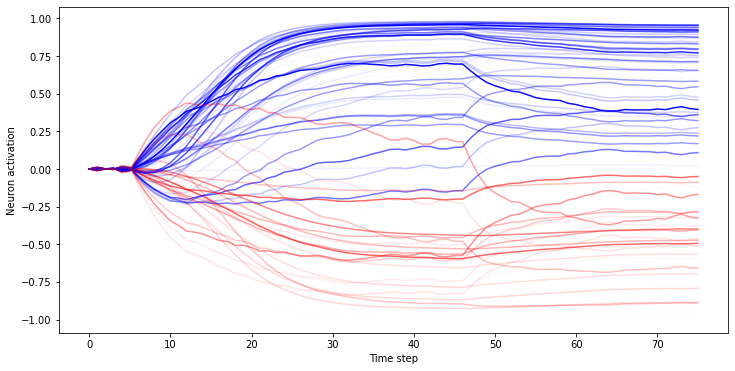

In [131]:
def plot_neuron_states(model, u, y,
                       figsize=(8, 6),
                      alpha=0.5,
                      apply_activation=False,
                      plot_by=''):
    """
    The weights are normalized by their max absolute value and used to control
    the alpha parameter of each line. 
    
    Param: 
    plot_by
        'weight' - Colors neurons with positive weights blue and negative red
        'adj_weight' - Each neuron is multiplied by the sign of its weight.
    """
        
    cmap = plt.cm.get_cmap('brg', model.network_size)

    plt.figure(figsize=figsize)
    plt.xlabel("Time step")
    plt.ylabel("Neuron value")
    if apply_activation:
        plt.ylabel("Neuron activation")
    plt.title("")
    
    z, activity = model(u, visible_activity=True) 
    if apply_activation:
        activity = model.activation(activity)
    activity = activity.detach().numpy()
    activity = activity.squeeze()
    w = model.w.detach().numpy().squeeze()
    max_abs_w = np.abs(w).max()
    w /= max_abs_w
    
    print(u.shape)
    
    for i in range(u.size(0)):
        
        color = cmap(i)
        act = activity.T[i]  
        
        if plot_by == 'weight':
            color = 'b'
            if w[i] < 0: color = 'r'           
            
        if plot_by == 'adj_weight':
            if w[i] < 0: act *= -1
            color = 'b'
            if act[-1] < 0: color = 'r'
        
          
        
        plt.plot(act, alpha=abs(w[i]), c=color)
    
    
u, y = single_decision(8*3.2/100)
u, y = torch.tensor(u, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
plot_neuron_states(model, u, y, figsize=(12, 6), apply_activation=True, plot_by='adj_weight')

### Network dynamics in m-I plane

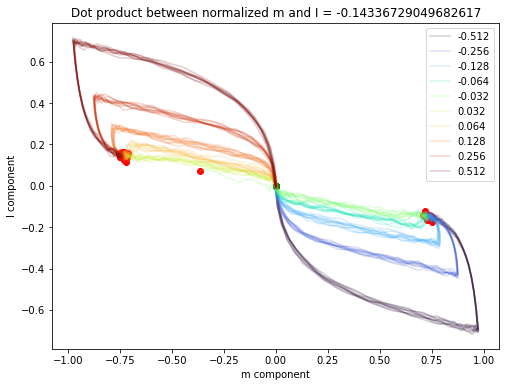

In [135]:
def plot_network_in_m_i(model, f_in_vec, in_params, 
                        num_repeat=10, 
                        figsize=(8,6),
                        alpha=0):
    
    if alpha==0:
        alpha = 1/num_repeat
    
    cmap = plt.cm.get_cmap('turbo', len(in_params))

    plt.figure(figsize=figsize)
    plt.xlabel("m component")
    plt.ylabel("I component")
    
    
    wi = model.wi.detach().numpy().squeeze()
    m = model.m.detach().numpy().squeeze()
    
    wi_dot_wi = wi.dot(wi)
    m_dot_m = m.dot(m)
    
    wi_norm = wi / wi_dot_wi**0.5
    m_norm = m / m_dot_m**0.5
    
    m_dot_wi = m_norm.dot(wi_norm)
    
    plt.title("Dot product between normalized m and I = {}".format(m_dot_wi))
    
    
    for idx, par in enumerate(in_params):
        for i in range(num_repeat):
            u, _ = f_in_vec(par)
            u = torch.tensor(u, dtype=torch.float32)
            z, unit_activity = model(u, visible_activity=True)
            unit_activity = unit_activity.detach().numpy().squeeze()
    #         print(wi.shape)
    #         print(unit_activity.shape)

            wi_comp = (wi @ unit_activity.T) / wi_dot_wi
            m_comp = (m @ unit_activity.T) / m_dot_m
            
            if i == 0:
                plt.plot(m_comp, wi_comp, color=cmap(idx), alpha=alpha, label=str(par))
            else:
                plt.plot(m_comp, wi_comp, color=cmap(idx), alpha=alpha)

            plt.scatter(m_comp[0], wi_comp[0], color='g')
            plt.scatter(m_comp[-1], wi_comp[-1], color='r')
            
    plt.legend()


plot_network_in_m_i(model, 
                    single_decision, 
                    (3.2/100)*np.array([-16, -8, -4, -2, -1, 1, 2, 4, 8, 16]), 
                    num_repeat=10,
                    alpha=0.2)
    